In [24]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

In [2]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

勾配確認

In [4]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [5]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [6]:
x_batch = x_train[:3]
t_batch = t_train[:3]

In [10]:
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

In [11]:
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:3.773691603144546e-10
b1:2.1527150263539376e-09
W2:5.581073635557015e-09
b2:1.4040217611588358e-07


誤差逆伝播法の実装

In [12]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [13]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [15]:
iters_num = 10000
train_size = x_train.shape[0]
print(train_size)
batch_size = 100
learning_rate = 0.1

60000


In [16]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [18]:
iter_per_epoch = max(train_size / batch_size, 1)
iter_per_epoch

600.0

In [19]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.11356666666666666 0.1074
0.9020833333333333 0.9037
0.92315 0.9253
0.9379666666666666 0.9359
0.94625 0.9441
0.9511833333333334 0.9477
0.9564166666666667 0.9538
0.9601 0.9582
0.9630833333333333 0.9599
0.9665 0.9609
0.9692333333333333 0.9635
0.9708833333333333 0.9639
0.9728666666666667 0.967
0.9739833333333333 0.9658
0.9746833333333333 0.9661
0.9766 0.9668
0.9767833333333333 0.9675


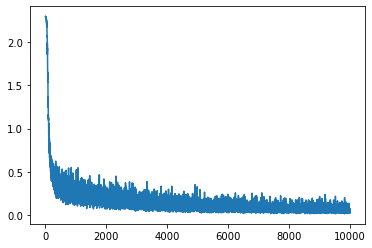

In [25]:
plt.plot(range(len(train_loss_list)), train_loss_list)